In [1]:
library(Seurat)
library(ggplot2)
library(cowplot)

Attaching SeuratObject



In [3]:
## load data
pc.filt.combined = readRDS("BMPC_SeuratObj.rds")

#### Figure 5 explored the BMPC apoptosis-associated gene expressions in each cell cluster and corresponding expression dynamics in each maturation path.

In [4]:
## load slingshot pseudotime data
load("pt.RData")

In [5]:
## Define apoptosis-assocated gene sets and initiate matrices to store the calculation results
gene4fig5 = list("Pro-survival" = c("MCL1","BCL2","BCL2L1","BCL2L2","BCL2L10","BCL2A1","XIAP","TSC22D3"),
                 "Intrinsic-apoptotic" = c("BCL2L11","BCL2L14","BAX","BAK1","BOK","BAD","BIK","BID","HRK","PMAIP1","BBC3","BMF","BNIP3","CASP3", "CASP7","DDIT3","CYCS","HTRA2","VDAC1","FOXO3"),
                 "Extrinsic-apoptotic" = c("FADD","DFFA","ATP11A","ATP11C","XKR8","ROCK1"),
                 "Cell cycle" = c("MKI67","CDK1","CDK2"),
                 "Cell cycle arrest" = c("CDKN1A","CDKN1B","CDKN2A","CDKN2C"))

ave4fig5 = matrix(0,nrow = nrow(pt),ncol = length(gene4fig5))
colnames(ave4fig5) = names(gene4fig5)
row.names(ave4fig5) = row.names(pt)

apoptotic.score = matrix(0,nrow = ncol(pc.filt.combined),ncol = length(names(gene4fig5)))
row.names(apoptotic.score) = row.names(pc.filt.combined@meta.data)
colnames(apoptotic.score) = names(gene4fig5)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


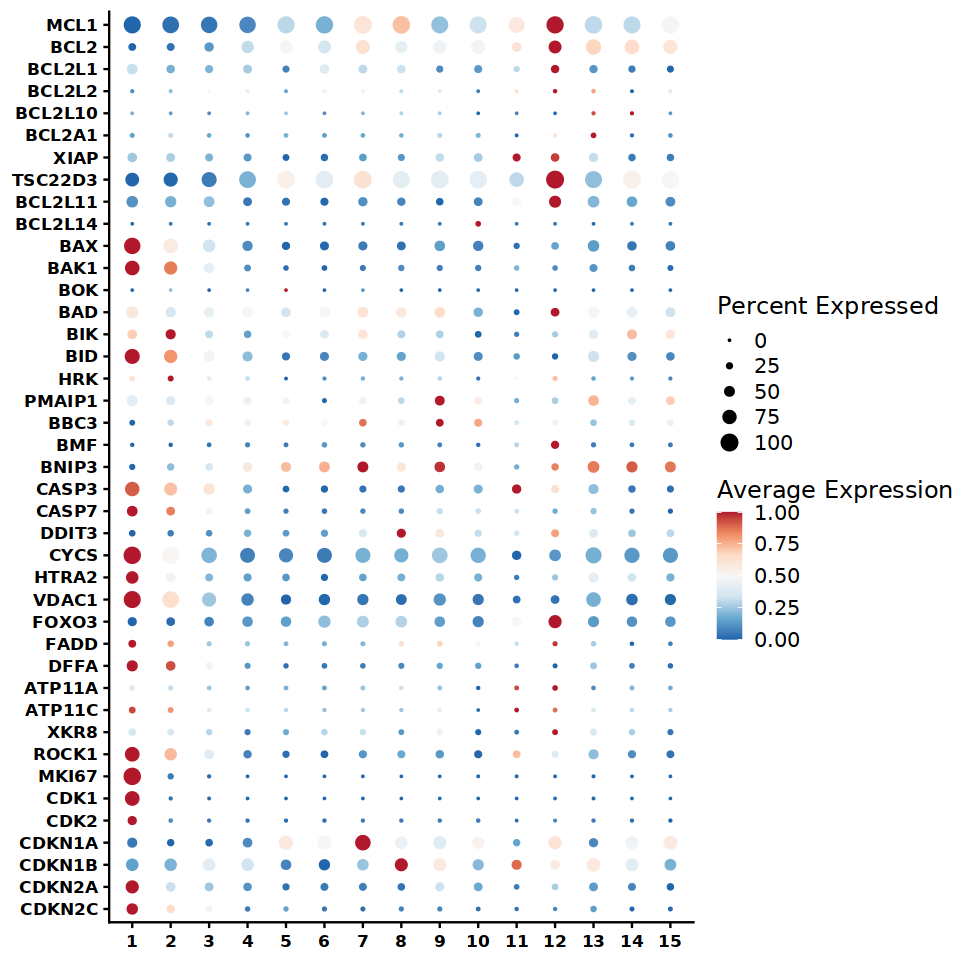

In [14]:
## Figure 5A
options(repr.plot.width=8, repr.plot.height=8)
gene = c("MCL1","BCL2","BCL2L1","BCL2L2","BCL2L10","BCL2A1","XIAP","TSC22D3",
         "BCL2L11","BCL2L14","BAX","BAK1","BOK","BAD","BIK","BID","HRK","PMAIP1","BBC3","BMF","BNIP3",
         "CASP3", "CASP7","DDIT3","CYCS","HTRA2","VDAC1","FOXO3","FADD","DFFA","ATP11A","ATP11C",
         "XKR8","ROCK1","MKI67","CDK1","CDK2","CDKN1A","CDKN1B","CDKN2A","CDKN2C")
dotplot(pc.filt.combined,features = gene,group.by = "cluster_id",
        scale.by = "radius",col.min = 0,assay = "RNA",scale = "mm",dot.scale = 4)+
  scale_color_distiller(palette = "RdBu",direction = -1)+ 
  RotatedAxis()+
  coord_flip()+
  theme(axis.title.x=element_blank(),axis.title.y=element_blank(),
        axis.text.x=element_text(angle = 0,vjust = 0.5,hjust = 0.5,colour="black",size = 10,face = "bold"))+ 
  theme(axis.text.y = element_text(size = 10,face = "bold"),legend.position = "right",plot.title = element_text(size=8,face = "bold"))


In [16]:
source("AverageExpression_manually.R")

Centering and scaling data matrix



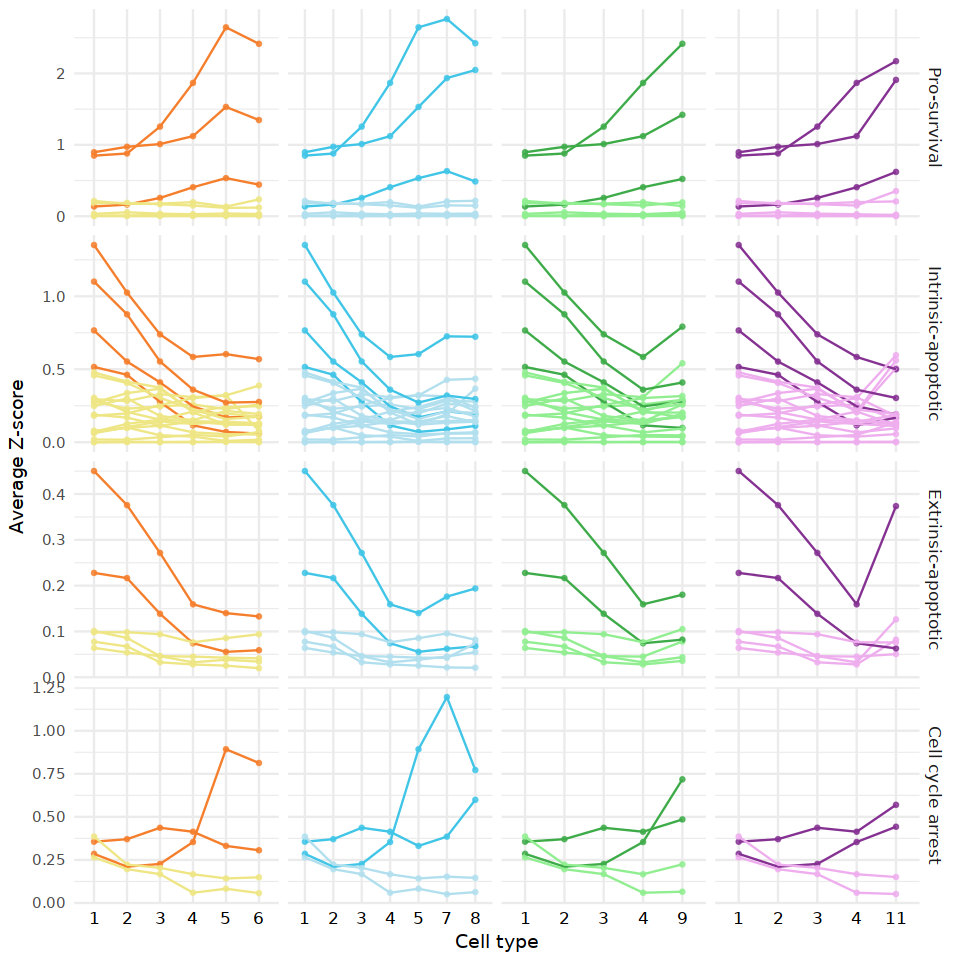

In [19]:
## Figure 5B
fig5b.data = AverageExpression_v4(pc.filt.combined,features = unlist(gene4fig5),assays = "RNA",group.by = "cluster_id",return.seurat = T)
fig5b.data = fig5b.data[["RNA"]]@data
fig5b.data.scl = t(apply(fig5b.data,1,scale))
colnames(fig5b.data.scl) = colnames(fig5b.data)
fig5b.data = as.data.frame(fig5b.data)
fig5b.data$gene = row.names(fig5b.data)
#fig5b4plot = melt(fig5b.data,id = "gene")

fig5b4plot = c()
fig5b4plot.scl = c()
for(i in names(gene4fig5)){
  index = list(path1 = c(1:6),path2 = c(1:5,7,8),path3 = c(1:4,9),path4 = c(1:4,11))
  for(j in names(index)){
    temp = fig5b.data[gene4fig5[[i]],index[[j]]]
    temp = as.data.frame(temp)
    temp$gene = row.names(temp)
    temp$gene_group = i
    temp$path = j
    temp4plot4 = melt(temp,id = c("gene","gene_group","path"))
    fig5b4plot = rbind(fig5b4plot,temp4plot4)
    
    temp = fig5b.data.scl[gene4fig5[[i]],index[[j]]]
    temp = as.data.frame(temp)
    temp$gene = row.names(temp)
    temp$gene_group = i
    temp$path = j
    temp4plot4 = melt(temp,id = c("gene","gene_group","path"))
    fig5b4plot.scl = rbind(fig5b4plot.scl,temp4plot4)
  }
}

fig5b4plot = subset(fig5b4plot,gene_group != "Cell cycle")
fig5b4plot.scl = subset(fig5b4plot.scl,gene_group != "Cell cycle")

## setting line color
line.color = c("khaki2","#F57E2C","lightblue2","#40C5E7","lightgreen","#3EAB49","plum2","#853192")
fig5b4plot$gene_group = factor(fig5b4plot$gene_group,levels = c("Pro-survival","Intrinsic-apoptotic","Extrinsic-apoptotic","Cell cycle arrest"))

fig5b4plot$gene_highlight = "N"
fig5b4plot$gene_highlight[fig5b4plot$gene %in% c("BCL2","MCL1","TSC22D3","BAX","BAK1","CYCS","VDAC1","DFFA","ROCK1","CDKN1A","CDKN1B")]  = "Y"
fig5b4plot$color = paste0(fig5b4plot$path,"-",fig5b4plot$gene_highlight)
ggplot(fig5b4plot,aes(x = factor(variable),y = value,group = gene,color = color)) + 
  geom_point(size = 0.8,alpha = 0.8) + scale_color_manual(values=line.color)+   #, shape=Status,)
  facet_grid(gene_group~path,scales = "free") +#,ncol = 4
  geom_line()+
  #geom_smooth(method = "loess",span = 0.6,se = FALSE,size = 0.75)+ #,color =c("#40C5E7","#3EAB49","#552E8C","#552E8C" )
  labs(x = "Cell type", y = "Average Z-score") +
  theme_minimal()+
  theme(axis.text.x=element_text(angle = 0,vjust = 1,hjust = 0.5,colour="black", size = 10),
        strip.background = element_blank(),
        strip.text = element_text(size=10),
        strip.text.x = element_blank(),legend.position = "none")